![title](https://image.ibb.co/erDntK/logo2018.png)

---




# Task 8 - PyTorch


You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. 

You've also worked hard to make your code efficient and vectorized.

For the this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, **PyTorch**


The goals of this assignment are as follows:

    * Use PyTorch at three different levels of abstraction,
    * Barebone PyTorch: work directly with low-level PyTorch Tensor graphs.
    * PyTorch Sequential API: use nn.Sequential to define a linear feed-forward network.
    * PyTorch Module API: use nn.Module to define arbitrary neural network architecture.



---
## About PyTorch


<img src="https://devblogs.nvidia.com/wp-content/uploads/2017/04/pytorch-logo-dark.png" alt="tensorflow" width="300px"/>

[PyTorch](https://pytorch.org/)  is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 


---

Working with PyTorch will give us benefits:

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.

* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 

* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 

* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

---
## GPU Runtime
Since we're going to use TensorFlow, we can utilize the GPU to accelerate the process

For that, make sure that this Colaboratory file is set to use GPU

* select **Runtime** in taskbar
* select **Change Runtime Type**
* choose Hardware accelerator **GPU**

<center>
  
![gpu](https://i.ibb.co/QX3Brf0/gpu.png)


---
---
#[Part 0] Import Libraries and Load Data

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

---
## 1 - Import Libraries

Import required libraries

In [0]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


---
## 2 - GPU Preparation

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


Write down your Name and Student ID

In [0]:
## --- start your code here ----

NIM = 1301160098
Nama = "Panji Bagaskara"

## --- end your code here ----

---
## 3 - Torchvision Transforms
The `torchvision.transforms` package provides tools for preprocessing data and for performing data augmentation; here we set up a transform to preprocess the data by subtracting the mean RGB value and dividing by the standard deviation of each RGB value; we've hardcoded the mean and std.

In [0]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

---
## 4 - Load CIFAR-10
We set up a Dataset object for each split (train / val / test); 

Datasets load training examples one at a time, so we wrap each Dataset in a DataLoader which iterates through the Dataset and forms minibatches. We divide the CIFAR-10 training set into train and val sets by passing a Sampler object to the DataLoader telling how it should sample from the underlying Dataset.

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


NUM_TRAIN = 49000

trainloader = DataLoader(trainset, batch_size=64, num_workers=2,
                        sampler=SubsetRandomSampler(range(NUM_TRAIN)))
valloader = DataLoader(valset, batch_size=64, num_workers=2,
                        sampler=SubsetRandomSampler(range(NUM_TRAIN, 50000)))
testloader = DataLoader(testset, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 85428826.54it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


---
---
# [Part 1] Barebones PyTorch


PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part 2 of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

---
## 1 - Flatten Function

A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

Run the code below to create flatten function

In [0]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


Test the implementation

In [7]:
x = torch.arange(12).view(2, 1, 3, 2)
print('Before flattening: ')
print(x)
print('\nAfter flattening: ')
print(flatten(x))

Before flattening: 
tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])

After flattening: 
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


**EXPECTED OUTPUT**:
<pre>
Before flattening: 
tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])

After flattening: 
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])

---
## 2 - Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [0]:
import torch.nn.functional as F  # useful stateless functions


def two_layer_fc(x, weights):
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = weights
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    scores = x.mm(w2)
    
    return scores

Test the network

In [9]:
hidden_layer_size = 42
x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)

scores = two_layer_fc(x, [w1, w2])
print(scores.size())  # you should see [64, 10]

torch.Size([64, 10])


**EXPECTED OUTPUT**:
<pre>
torch.Size([64, 10])

---
## 3 - Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. 


---
#### <font color='red'>**EXERCISE:** </font>

    Implement three_layer_convnet() function
    
The network should have the following architecture:

1. A convolutional layer `conv_w1` (with bias `conv_b1`), and `zero-padding = 2`
2. ReLU nonlinearity
3. A convolutional layer `conv_w2` (with bias `conv_b2`), and `zero-padding = 1`
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [0]:
def three_layer_convnet(x, weights):

    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = weights
    
    # call F.conv2d with input x and corresponding weights, bias, and padding size
    conv1 = F.conv2d(x, weight=conv_w1, bias=conv_b1, padding=2)
    
    # call F.relu with input from conv1 graph
    relu1 = F.relu(conv1)
    
    # call F.conv2d with input x and corresponding weights, bias, and padding size    
    conv2 = F.conv2d(relu1, weight=conv_w2, bias=conv_b2, padding=1)
    
    # call F.relu with input from conv2 graph
    relu2 = F.relu(conv2)
    
    # call flatten function with input from relu2 graph
    relu2_flat = flatten(relu2)
    
    # score is matrix multiplication (.mm) from relu2_flat and fc_w added by bias fc_b
    scores = relu2_flat.mm(fc_w) + fc_b

    
    return scores

Test the network

In [11]:
x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
conv_b1 = torch.zeros((6,))  # out_channel
conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
conv_b2 = torch.zeros((9,))  # out_channel

# you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
fc_w = torch.zeros((9 * 32 * 32, 10))
fc_b = torch.zeros(10)

weights = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
scores = three_layer_convnet(x, weights)
print(scores.size())  # you should see [64, 10]

torch.Size([64, 10])


**EXPECTED OUTPUT**:
<pre>
torch.Size([64, 10])

---
## 4 - Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [0]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
        
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)



create a weight of shape [3 x 5]

you should see the type `torch.cuda.FloatTensor` if you use GPU. 

Otherwise it should be `torch.FloatTensor`

In [13]:
random_weight((3, 5))

tensor([[ 0.5709, -1.3151,  0.1658,  0.3675, -0.6905],
        [-0.1682, -0.7479,  0.3961, -0.2371, -0.5674],
        [ 0.6340, -0.4587, -0.2955,  0.2704,  0.7537]], device='cuda:0',
       requires_grad=True)

**EXPECTED OUTPUT**:
<pre>
(for GPU use)
tensor([[ 0.1341, -0.1242, -0.1948, -0.9173, -1.1082],
        [-0.3236,  0.3774,  0.2417,  0.8203, -0.0587],
        [-0.5814,  0.2702, -0.0934, -0.0985,  0.7206]], 
        device='cuda:0', requires_grad=True)

---
## 5 - Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [0]:
def check_accuracy(loader, model_fn, weights):
    
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            
            scores = model_fn(x, weights)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()            
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

---
## 6 - Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [0]:
def train(model_fn, params, lr):
    
    for t, (x, y) in enumerate(trainloader):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= lr * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy(valloader, model_fn, params)
            print()

---
---
# [Part 2] BareBones PyTorch Train

after we define the bare-bones network, let's try to train them

---
## 1 - Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over `10 classes`. 


---
#### <font color='red'>**EXERCISE:** </font>

    Train a Two-Layer Network
    

You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 40%** after training for **ONE EPOCH**.

In [16]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.6708
Checking accuracy on the val set
Got 144 / 1000 correct (14.40%)

Iteration 100, loss = 2.2187
Checking accuracy on the val set
Got 371 / 1000 correct (37.10%)

Iteration 200, loss = 1.8894
Checking accuracy on the val set
Got 376 / 1000 correct (37.60%)

Iteration 300, loss = 1.7693
Checking accuracy on the val set
Got 407 / 1000 correct (40.70%)

Iteration 400, loss = 1.5417
Checking accuracy on the val set
Got 427 / 1000 correct (42.70%)

Iteration 500, loss = 1.6176
Checking accuracy on the val set
Got 401 / 1000 correct (40.10%)

Iteration 600, loss = 1.8266
Checking accuracy on the val set
Got 455 / 1000 correct (45.50%)

Iteration 700, loss = 1.7501
Checking accuracy on the val set
Got 421 / 1000 correct (42.10%)



**EXPECTED OUTPUT**:
<pre>
loss should start around 3 and end around 1.7
with accuracy start around 17% and end above 40% 

---
## 2 - Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with `32 channels output` of `5x5` filters, with `zero-padding of 2`
2. ReLU
3. Convolutional layer (with bias) with `16 channels output` of `3x3` filters, with `zero-padding of 1`
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.



---
#### <font color='red'>**EXERCISE:** </font>

    Train a three-layer ConvNet
    

You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 42%** after training for **ONE EPOCH**.

In [17]:
learning_rate = 3e-3
num_class = len(classes)

channel_input = 3
channel_1_out = 32
channel_2_out = 16
filter_1_size = (5,5)
filter_2_size = (3,3)

# conv_w1 is random_weight with input channel_1_out, channel_input, 
# and the corresponding filter_width, filter_height
conv_w1 = random_weight((channel_1_out, channel_input, 5, 5))

# conv_b1 is zero_weight with input channel_1_out
conv_b1 = zero_weight((channel_1_out,))

# conv_w2 is random_weight with input channel_2_out, channel_1_out, 
# and the corresponding filter_width, filter_height
conv_w2 = random_weight((channel_2_out, channel_1_out, 3, 3))

# conv_b2 is zero_weight with input channel_2_out
conv_b2 = zero_weight((channel_2_out,))

# fc_w is random_weight with input channel_2_out*32*32, num_class
fc_w = random_weight((channel_2_out*32*32, num_class))

# fc_b is zero_weight with input num_class
fc_b = zero_weight((num_class,))

print('w1 shape = ',conv_w1.shape)
print('w2 shape = ',conv_w2.shape)


w1 shape =  torch.Size([32, 3, 5, 5])
w2 shape =  torch.Size([16, 32, 3, 3])


**EXPECTED OUTPUT**:
<pre>
w1 shape =  torch.Size([32, 3, 5, 5])
w2 shape =  torch.Size([16, 32, 3, 3])

In [18]:
weights = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]

train(three_layer_convnet, weights, learning_rate)

Iteration 0, loss = 3.4415
Checking accuracy on the val set
Got 118 / 1000 correct (11.80%)

Iteration 100, loss = 1.7719
Checking accuracy on the val set
Got 339 / 1000 correct (33.90%)

Iteration 200, loss = 1.7342
Checking accuracy on the val set
Got 412 / 1000 correct (41.20%)

Iteration 300, loss = 1.9373
Checking accuracy on the val set
Got 396 / 1000 correct (39.60%)

Iteration 400, loss = 1.6926
Checking accuracy on the val set
Got 435 / 1000 correct (43.50%)

Iteration 500, loss = 1.5107
Checking accuracy on the val set
Got 439 / 1000 correct (43.90%)

Iteration 600, loss = 1.4984
Checking accuracy on the val set
Got 450 / 1000 correct (45.00%)

Iteration 700, loss = 1.7000
Checking accuracy on the val set
Got 465 / 1000 correct (46.50%)



**EXPECTED OUTPUT**:
<pre>
loss should start around 3 and end around 1.7
with accuracy start around 17% and end above 42% 

---
---
# [Part 3] PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. 



In previous part, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. 
It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part 3.

---
## 1 - Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [0]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        
        # assign layer objects to class attributes        
        self.fc1 = nn.Linear(input_size, hidden_size)      
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        # initialize its weights
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)        
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

Now, let's test the implementation

In [20]:
input_size = 50
x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
model = TwoLayerFC(input_size, 42, 10)
scores = model(x)
print(scores.size())  # you should see [64, 10]

torch.Size([64, 10])


**EXPECTED OUTPUT**:
<pre>
torch.Size([64, 10])

---
## 2 - Three-Layer ConvNet

It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in `Part 3`:

1. Convolutional layer with `channel_1` of `5x5` filters, with `zero-padding of 2`
2. ReLU
3. Convolutional layer with `channel_2` of `3x3` filters, with `zero-padding of 1`
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.



---
#### <font color='red'>**EXERCISE:** </font>

    Implement three-layer ConvNet class
    

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

In [0]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        
        # conv1 is nn.Conv2d with input in_channel, channel_1, 
        # and the corresponding kernel_size, and padding
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2, bias=True)     
        
        # conv2 is nn.Conv2d with input channel_1, channel_2, 
        # and the corresponding kernel_size, and padding 
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1, bias=True)     
        
        # fc is nn.Linear with input channel_2*32*32, num_classes
        self.fc = nn.Linear(channel_2*32*32, num_classes)
        
        
        ########################################################################
        # initialize weights
        ########################################################################
        # initialize conv1 weight with kaiming normal
        nn.init.kaiming_normal_(self.conv1.weight)
        
        # initialize conv1 bias with constant zeros
        nn.init.constant_(self.conv1.bias, 0)
        
        # initialize conv2 weight with kaiming normal
        nn.init.kaiming_normal_(self.conv2.weight)

        # initialize conv2 bias with constant zeros
        nn.init.constant_(self.conv2.bias, 0)

        # initialize fc weight with kaiming normal
        nn.init.kaiming_normal_(self.fc.weight)

        # initialize fc bias with constant zeros
        nn.init.constant_(self.fc.bias, 0)
        
        
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        
        
        # call self.conv1() graph using input x
        conv1 = self.conv1(x)
        
        # call F.relu() with input conv1
        relu1 = F.relu(conv1)
        
        # call self.conv2() graph using input relu1
        conv2 = self.conv2(relu1)
        
        # call F.relu() with input from conv2
        relu2 = F.relu(conv2)
        
        # call flatten() function using input relu2
        relu2_flat = flatten(relu2)
        
        # call self.fc() with input relu2_flat
        scores = self.fc(relu2_flat)
        
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores



After you implement the three-layer ConvNet, test your implementation; 
it should print `(64, 10)` for the shape of the output scores.

In [22]:
x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)

scores = model(x)

print(scores.size())  # you should see [64, 10]

torch.Size([64, 10])


**EXPECTED OUTPUT**:
<pre>
torch.Size([64, 10])

---
## 3 - Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part 3. You don't manually pass in the parameters anymore.

In [0]:
def check_accuracy_module(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

---
## 4 - Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [0]:
def train_module(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(trainloader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_module(valloader, model)
                print()

---
## 5 - Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part 3, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.


---
#### <font color='red'>**EXERCISE:** </font>

    Train a Two-Layer Network
    

You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 40%** after training for **ONE EPOCH**.

In [25]:
hidden_layer_size = 4000
learning_rate = 1e-2

model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_module(model, optimizer)

Iteration 0, loss = 3.2783
Checking accuracy on validation set
Got 170 / 1000 correct (17.00)

Iteration 100, loss = 2.1729
Checking accuracy on validation set
Got 315 / 1000 correct (31.50)

Iteration 200, loss = 2.0391
Checking accuracy on validation set
Got 348 / 1000 correct (34.80)

Iteration 300, loss = 1.6789
Checking accuracy on validation set
Got 404 / 1000 correct (40.40)

Iteration 400, loss = 1.7749
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Iteration 500, loss = 1.7426
Checking accuracy on validation set
Got 399 / 1000 correct (39.90)

Iteration 600, loss = 1.8422
Checking accuracy on validation set
Got 438 / 1000 correct (43.80)

Iteration 700, loss = 1.3623
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)



**EXPECTED OUTPUT**:
<pre>
loss should start around 4 and end around 1.7
with accuracy start around 10% and end above 40% 

---
## 6 - Train a Three-Layer ConvNet

You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! 

You should train the model using stochastic gradient descent WITHOUT momentum.

---
#### <font color='red'>**EXERCISE:** </font>

    Train a three-layer ConvNet
    use Vanilla SGD
    

You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 45%** after training for **ONE EPOCH**.

In [26]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

# call ThreeLayerConvNet() function with input channel_input, channel_1, channel_2, and num_class
model = ThreeLayerConvNet(channel_input, channel_1, channel_2, num_class)

# define optimizer from optim.SGD() with input from model.parameters() and learning_rate
optimizer = optim.SGD(model.parameters(), learning_rate)


train_module(model, optimizer)

Iteration 0, loss = 3.2351
Checking accuracy on validation set
Got 123 / 1000 correct (12.30)

Iteration 100, loss = 1.9982
Checking accuracy on validation set
Got 333 / 1000 correct (33.30)

Iteration 200, loss = 1.7748
Checking accuracy on validation set
Got 386 / 1000 correct (38.60)

Iteration 300, loss = 1.8380
Checking accuracy on validation set
Got 418 / 1000 correct (41.80)

Iteration 400, loss = 1.6802
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)

Iteration 500, loss = 1.5176
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Iteration 600, loss = 1.6535
Checking accuracy on validation set
Got 467 / 1000 correct (46.70)

Iteration 700, loss = 1.6629
Checking accuracy on validation set
Got 475 / 1000 correct (47.50)



**EXPECTED OUTPUT**:
<pre>
loss should start around 3 and end around 1.6
with accuracy start around 10% and end above 45% 

---
---
# [Part 4] PyTorch Sequential API
In previous part, introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. 

Is there a more convenient way? 




Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

In [0]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
# Weight initialization
# Ref: http://pytorch.org/docs/stable/nn.html#torch.nn.Module.apply
def init_weights(m):
    # print(m)
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        random_weight(m.weight.size())
        zero_weight(m.bias.size())

---
## 1 - Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, You **DON'T NEED** to tune any hyperparameters but you should achieve **ABOVE 40%** after training for **ONE EPOCH**


---
#### <font color='red'>**EXERCISE:** </font>

    Train a Two-Layer Network
    

You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 40%** after training for **ONE EPOCH**.

In [28]:
hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_module(model, optimizer)

Iteration 0, loss = 2.3028
Checking accuracy on validation set
Got 167 / 1000 correct (16.70)

Iteration 100, loss = 1.5625
Checking accuracy on validation set
Got 398 / 1000 correct (39.80)

Iteration 200, loss = 1.6593
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Iteration 300, loss = 1.8408
Checking accuracy on validation set
Got 448 / 1000 correct (44.80)

Iteration 400, loss = 1.7719
Checking accuracy on validation set
Got 411 / 1000 correct (41.10)

Iteration 500, loss = 1.6660
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 600, loss = 1.6503
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Iteration 700, loss = 1.9886
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)



**EXPECTED OUTPUT**:
<pre>
loss should start around 3 and end around 1.7
with accuracy start around 16% and end above 40% 

---
## 2 - Three-Layer ConvNet

Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in `Part 3`:

1. Convolutional layer with `channel_1` of `5x5` filters, with `zero-padding of 2`
2. ReLU
3. Convolutional layer with `channel_2` of `3x3` filters, with `zero-padding of 1`
4. ReLU
5. Fully-connected layer to `num_classes` classes


You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with `Nesterov momentum 0.9`.


---
#### <font color='red'>**EXERCISE:** </font>

    Train a three-layer ConvNet
    use Nesterov Update with Momentum=0.9
    

Again, You <font color='red'>**DON'T NEED**</font> to tune any hyperparameters but you should see accuracies **ABOVE 55%** after training for **ONE EPOCH**.

In [29]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2


################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part 4 with the             #
# Sequential API.                                                              #
################################################################################

model = nn.Sequential(
    
    # add nn.Conv2d() with input channel_input, channel_1, 
    # and the corresponding kernel size and padding
    nn.Conv2d(channel_input, channel_1, kernel_size=5, padding=2),
    
    # add nn.Relu()
    nn.ReLU(),
    
    # add nn.Conv2d() with input channel_1, channel_2, 
    # and the corresponding kernel size and padding
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
    
    # add nn.Relu()
    nn.ReLU(),
    
    # add Flatten() class defined above
    Flatten(),
    
    # lastly add nn.Linear() with input channel_2*32*32, num_class
    nn.Linear(channel_2*32*32, num_class),
    
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

model.apply(init_weights)
train_module(model, optimizer)

Iteration 0, loss = 2.2956
Checking accuracy on validation set
Got 114 / 1000 correct (11.40)

Iteration 100, loss = 1.4136
Checking accuracy on validation set
Got 454 / 1000 correct (45.40)

Iteration 200, loss = 1.2477
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)

Iteration 300, loss = 1.2673
Checking accuracy on validation set
Got 545 / 1000 correct (54.50)

Iteration 400, loss = 1.2133
Checking accuracy on validation set
Got 549 / 1000 correct (54.90)

Iteration 500, loss = 1.1649
Checking accuracy on validation set
Got 560 / 1000 correct (56.00)

Iteration 600, loss = 1.1424
Checking accuracy on validation set
Got 577 / 1000 correct (57.70)

Iteration 700, loss = 1.1987
Checking accuracy on validation set
Got 587 / 1000 correct (58.70)



**EXPECTED OUTPUT**:
<pre>
loss should start around 2.5 and end around 1.2
with accuracy start around 15% and end above 55% 

---
---
# [Part 5] CIFAR-10 Open-ended Challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with **architectures**, **hyperparameters**, **loss functions**, **regularization**, or anything else you can think of to train a model 

You should achieve <font color='blue' size='5'><b>at least 75% accuracy</b></font> on the **validation** set <font color='red' size='4'><b>within 10-20 epochs</b></font>. 


You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 


---
## Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?

- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?

- **Pooling**: We didn't use any pooling above. Would this improve the model?

- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?

- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?<br>Good architectures to try include:
    - `[conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]`
    - `[conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]`
    - `[batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]`

- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.

- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

- **Optimization**: You've seen various advanced optimization function. Maybe changing the optimization using Adam or RMSProp will increase the accuracy?

<br><center>
<font color='red' size='4'><b>--- We define initial net, but you can change the network however you want ---<br>--- You must design YOUR OWN Architecture --- <br>
--- And train it from scratch --- </b></font>

---
## Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. 

When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations

- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.

- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

<center>
<h2><font color='blue'>--- Go Wild, Have Fun, and Happy Training!  --- </font></h2>

---
## 1 - Define Model

---
#### <font color='red'>**EXERCISE:** </font>

    Design your Convolutional Neural Network Architecture

    

In [0]:
# A 4-layer convolutional network
# 3x[conv - relu - maxpool]-> fc

layer1 = nn.Sequential(
    nn.Conv2d(channel_input, 32, kernel_size=5, padding=2),
    nn.ReLU()
#    nn.MaxPool2d(2)
)

layer2 = nn.Sequential(
    nn.Conv2d(32, 16, kernel_size=3, padding=1),
    nn.ReLU()
#    nn.MaxPool2d(2)
)

# layer3 = nn.Sequential(
#    nn.Conv2d(32, 16, kernel_size=3, padding=1),
#    nn.ReLU(),
#    nn.MaxPool2d(2)
#)

fc = nn.Linear(16*32*32, num_class)

model = nn.Sequential(
    layer1,
    layer2,
    # layer3,
    Flatten(),
    fc
)


---
## 2 - Train Model

---
#### <font color='red'>**EXERCISE:** </font>

    Choose optimizer
    Train the model
    

In [89]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


# Print training status every epoch: set print_every to a large number
print_every = 10000

# You should get at least 70% accuracy
train_module(model, optimizer, epochs=10)

Iteration 0, loss = 2.3125
Checking accuracy on validation set
Got 129 / 1000 correct (12.90)



KeyboardInterrupt: ignored

---
## 3 - Evaluate Model

---
#### <font color='red'>**EXERCISE:** </font>

    evaluate your model on test set
    

In [0]:
check_accuracy_module(trainloader, model)
check_accuracy_module(valloader, model)
check_accuracy_module(testloader, model)

Checking accuracy on validation set
Got 44752 / 49000 correct (91.33)
Checking accuracy on validation set
Got 615 / 1000 correct (61.50)
Checking accuracy on test set
Got 5785 / 10000 correct (57.85)


**EXPECTED OUTPUT**:
<pre>
you should get above 75% of accuracy for train, val, and test set

---
## 4 - Test Model on New Image

For this part, you have to test your model on new image

First of all, search for five images on the Internet, then list the URLs to the code below.

The five images must belong to the 10 CIFAR-10 classes that the model recognizes.

---
#### <font color='red'>**EXERCISE:** </font>

    define five image urls
    one image has been given for an example, you can change it

In [0]:
!wget -q -O 'data_test_0.jpg' 'https://ichef.bbci.co.uk/news/912/cpsprodpb/160B4/production/_103229209_horsea.png'
!wget -q -O 'data_test_1.jpg' 'https://cdn1.imggmi.com/uploads/2019/10/6/964db084139e28ba41cd3b0c92206abe-full.jpg'
!wget -q -O 'data_test_2.jpg' 'https://cdn1.imggmi.com/uploads/2019/10/6/ab55a19ca3823f1e1a51e11efa7ecd76-full.jpg'
!wget -q -O 'data_test_3.jpg' 'https://cdn1.imggmi.com/uploads/2019/10/6/c9b176da417ae359a7fe003727e7e393-full.jpg'
!wget -q -O 'data_test_4.jpg' 'https://cdn1.imggmi.com/uploads/2019/10/6/f8db0992c8af364676b4ac0c4fb21e20-full.jpg'

Run and Recognize the images

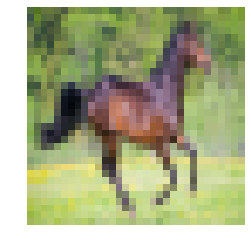

predicted id   : 3
predicted id   : tensor(3, device='cuda:0')
predicted class: cat
--------------------------------




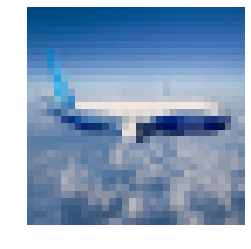

predicted id   : 0
predicted id   : tensor(0, device='cuda:0')
predicted class: plane
--------------------------------




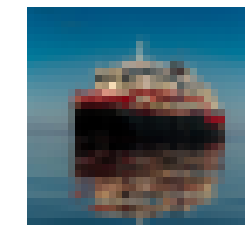

predicted id   : 8
predicted id   : tensor(8, device='cuda:0')
predicted class: ship
--------------------------------




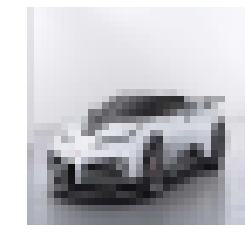

predicted id   : 1
predicted id   : tensor(1, device='cuda:0')
predicted class: car
--------------------------------




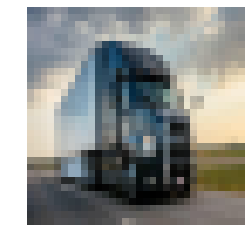

predicted id   : 9
predicted id   : tensor(9, device='cuda:0')
predicted class: truck
--------------------------------




In [0]:
import cv2 as cv
from PIL import Image
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


for i in range(5):
  new_img = Image.open('data_test_'+str(i)+'.jpg')
  new_img = np.array(new_img)
  new_img2 = cv.resize(new_img, (32,32), interpolation=cv.INTER_AREA)
  plt.imshow(new_img2)
  plt.axis('off')
  plt.show()

  new_img2 = new_img2.transpose(2,0,1).astype('float32')
  new_img2 = torch.from_numpy(np.expand_dims(new_img2,0)).float().to(device)
  pred = model(new_img2)
  class_id = torch.argmax(pred)
  print('predicted id   :',(class_id.data).cpu().numpy())
  print('predicted id   :',class_id)
  print('predicted class:', class_names[class_id])
  print('--------------------------------\n\n')


---

# Congratulation, You've Completed Exercise 8

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2019 - ADF</a> </p>

![footer](https://image.ibb.co/hAHDYK/footer2018.png)